In [1]:
import pandas as pd
import numpy as np
import gzip
import os
import datetime
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import gc
import re
#import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib
import pandas_ta as ta

import warnings

import requests

import hmac
import hashlib

import aiohttp
import asyncio

import logging
from datetime import timezone

import nest_asyncio

# Filter depreciation warnings from pandas regarding the append method
warnings.filterwarnings('ignore', category=FutureWarning, message=".*append.*")
pd.options.mode.chained_assignment = None

# Set pandas to display all digits for floating-point numbers
pd.options.display.float_format = '{:.8f}'.format

import os
from dotenv import load_dotenv

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Ignore only FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Ignore only RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

import importlib


from Orats_options_fetch_functions import *

from faster_numba_strategy_functions import *

import strategy_functions

importlib.reload(strategy_functions)
from strategy_functions import *

# import Common_functions

# importlib.reload(strategy_functions)
# importlib.reload(Common_functions)

# from Common_functions import *
# coin_desk_api_key =  "e43c1fd991e660b9bf959645f0800bb7e76fb4a3537ab773cec62b2fad31af2d"
from datetime import time
from pathlib import Path
# Get the user's home directory dynamically
home_dir = r"C:\Data\Options_logs"
#====================================

strategy_name = "Spread_ROC_Arb"

# Create a folder for the strategy_name if it doesn't exist in home directory

strategy_folder = os.path.join(home_dir, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")

#=== location to store the trade dataframe for debug

base_folder_df = "strategy_dataframe"
df_folder = os.path.join(strategy_folder, base_folder_df)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
    print("\n Created strategy dataframe folder : " ,df_folder )

#----- symbol_wise_trades

trades_folder = "sym_wise_trades"
trades_strategy_folder = os.path.join(strategy_folder, trades_folder)

if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)

logger = setup_logger("Spread_ROC_Arb", strategy_folder, log_file="strategy.log" , to_console=False)


In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to an in-memory database
con = duckdb.connect()

# --- Your setup code (which is correct) ---
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")
con.execute("""
SET s3_endpoint='122.176.133.73:9000';
SET s3_use_ssl=false;
SET s3_access_key_id='minioadmin';
SET s3_secret_access_key='minioadmin';
""")
con.execute("SET s3_url_style='path';") 
con.execute("PRAGMA threads=8;")
con.execute("PRAGMA enable_object_cache;")

# --- THE MISSING STEP: Querying a file from S3 ---
# Replace with your actual S3 bucket and file path
# This can be a .parquet, .csv, or .json file
s3_file_path = 's3://duckdata/ORATS/Options/**/*.parquet'

try:
    # Execute a query on the S3 file and fetch the result as a Pandas DataFrame
    print(f"Querying data from: {s3_file_path}")
    df = con.execute(f"""
        SELECT *
        FROM '{s3_file_path}'
        LIMIT 2;
    """).df()

    print("\n✅ Query successful! First 5 rows of data:")
    print(df.head())

except Exception as e:
    print(f"\n❌ An error occurred during the query: {e}")

# finally:
#     # It's good practice to close the connection
#     con.close()

Querying data from: s3://duckdata/ORATS/Options/**/*.parquet

✅ Query successful! First 5 rows of data:
      expiry       strike  dte  optionType                  ts         low  \
0 2024-01-26 421.00000000   25          -1 2024-01-02 17:13:00 17.18000000   
1 2024-01-12 414.00000000   11          -1 2024-01-02 17:13:00 10.41500000   

         high        open       close     volume  ...      askSize  \
0 17.18000000 17.18000000 17.18000000 0.00000000  ...  50.00000000   
1 10.41500000 10.41500000 10.41500000 0.00000000  ... 151.00000000   

     bidPrice    askPrice      bidIv      askIv         iv          oi  \
0 17.12000000 17.24000000 0.13785700 0.14511500 0.14148600 15.00000000   
1 10.34000000 10.49000000 0.14267100 0.15199600 0.14733300 54.00000000   

    stockPrice        day ticker  
0 404.00000000 2024-01-02    QQQ  
1 404.00000000 2024-01-02    QQQ  

[2 rows x 21 columns]


In [3]:


ifol = r"C:\Data\Aggregate_Data\Options\USA\Raw_SPY_1min_2024_2025_ORATS_close.parquet"
#== read the RELIANCE data

com_df2 = pd.read_parquet(ifol)

if 'timestamp' in com_df2.columns:
    com_df2['timestamp'] = pd.to_datetime(com_df2['timestamp'])
    com_df2.set_index('timestamp', inplace=True)



com_df2 = com_df2[~com_df2.index.duplicated(keep='first')]


com_df2.dropna(how='all', inplace=True)

vix_df = pd.read_parquet(r"C:\Data\Aggregate_Data\VIX_1_min_2019_2025.parquet")
com_df2 = com_df2.join(vix_df)


final_symbols = com_df2.filter(like='close').columns.str.replace('_close', '')
print("Total symbols found after all filtering: ", len(final_symbols))

# Calculate the number of rows in the DataFrame

com_df2[[f"{symbol}_intraday_low" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_low(com_df2, low_col=x.name,agg_func='min'))

com_df2[[f"{symbol}_intraday_high" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_high(com_df2, high_col=x.name,agg_func='max'))

com_df2[[f"{symbol}_todayo" for symbol in final_symbols]] = com_df2[[f'{symbol}_close' for symbol in final_symbols]].resample('D').transform('first')

# com_df2[[f"{symbol}_daily_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=50)

# com_df2[[f"{symbol}_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change()

# com_df2[[f"{symbol}_ROC_4" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=4)

com_df2[[f"{symbol}_prevdayl" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_prevdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_secdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=2, column=x.name))


# This single call does it for the 20-day MA
ma_20d_df = calculate_daily_ma_vectorized(df=com_df2, symbols=final_symbols, periods=3 , agg_func='last' , col_suffix='close')

    # Join the new features back to the main DataFrame
com_df2 = pd.concat([com_df2, ma_20d_df] , axis=1 , join='outer')


com_df2[[f"{symbol}_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(2).mean()

com_df2[[f"{symbol}_ROC_30" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].pct_change(periods=30)


#com_df2[[f"{symbol}_ma_3d_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].values / com_df2[[f"{symbol}_3d_MA" for symbol in final_symbols]].values

com_df2[[f"{symbol}_prevdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=1))

com_df2[[f"{symbol}_secdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=2))


# #=== hourly volume
# com_df2[[f"{symbol}_vol_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].rolling(4).mean()

# #==avg 3 day volume

# com_df2[[f"{symbol}_3d_vol_MA" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].apply(lambda x: daily_moving_average(com_df2, timeframe='1D', column=x.name, periods=3, agg_func='last'))

com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(5).mean()


com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3dhigh" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=3, column=x.name))



# 1. Get the lists of column names
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]

# 2. Perform the calculation on NumPy arrays
range_values = (com_df2[high_3d_cols].values / com_df2[low_3d_cols].values) - 1

# 3. Create a new DataFrame from the results
# This is the key step to avoid the error.
range_cols = [f"{symbol}_3d_rng" for symbol in final_symbols]
range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# 4. Join the new DataFrame back to the main one
com_df2 = com_df2.join(range_df)



# # Calculate highest high of last 4 bars
# com_df2[[f"{symbol}_high_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).max()

# # Calculate lowest low of last 4 bars
# com_df2[[f"{symbol}_low_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).min()

# # 1. Get the lists of column names
# high_cols = [f"{symbol}_high_4bar" for symbol in final_symbols]
# low_cols = [f"{symbol}_low_4bar" for symbol in final_symbols]

# # 2. Perform the calculation on the NumPy arrays
# range_values = com_df2[high_cols].values - com_df2[low_cols].values

# # 3. Create a new DataFrame from the result (This is the key step)
# range_cols = [f"{symbol}_range_4bar" for symbol in final_symbols]
# range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# # 4. Join the new DataFrame back to the main one
# com_df2 = com_df2.join(range_df)


# # Calculate mean range (average of the 4-bar ranges)
# com_df2[[f"{symbol}_mean_range_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_range_4bar" for symbol in final_symbols]].rolling(12).mean()


# gc.collect()

# for symbol in final_symbols:

   
#     com_df2[f'{symbol}_iATR2'] = com_df2[f"{symbol}_ATR"].values / com_df2[f"{symbol}_close"].values


# 1. Define the column groups
close_cols = [f"{symbol}_close" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]

# 2. Perform the calculation in a more chained and memory-conscious way
# Using .to_numpy(dtype=np.float32) can cut memory usage by 50%
numerator = com_df2[close_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)
denominator = com_df2[high_3d_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)

# np.divide handles division by zero safely
percentile_values = np.divide(numerator, denominator, where=denominator != 0)

# 3. Create the new feature DataFrame
pctl_cols = [f"{symbol}_3d_Pctl" for symbol in final_symbols]
percentile_df = pd.DataFrame(percentile_values, index=com_df2.index, columns=pctl_cols)

# 4. Clip values and join back (same as your code)
percentile_df = percentile_df.clip(0, 1)
com_df2 = com_df2.join(percentile_df)

com_df2['decent'] = np.where((com_df2['SPY_todayo'] > com_df2['SPY_prevdayc'] * 0.985) & (com_df2['SPY_todayo'] > com_df2['SPY_prevdayc'] * 0.98), 1, 0)
com_df = com_df2[com_df2['decent']==1]
com_df = com_df[com_df.index.year>=2024]

Total symbols found after all filtering:  2
Calculating 3-day MA for 2 symbols...


In [4]:

def fetch_bulk_option_data_call_put(con, ticker, end_date_str, n_days, strikes: List[float], expiries: List[str] , option_type: int = 0 ):
    
    """
    Fetches a range of minute-level data for MULTIPLE option contracts
    in a single, efficient query.

    Args:
        con: The database connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        end_date_str (str): The end date for the data fetch in 'YYYY-MM-DD' format.
        n_days (int): The number of business days to look back.
        strikes (List[float]): A list of strike prices to fetch.
        expiries (List[str]): A list of expiry dates in 'YYYY-MM-DD' format.
        option_type (int, optional): The type of option to fetch. 
                                     1 for Calls, -1 for Puts, 0 for Both. 
                                     Defaults to 0.
    
    Returns:
        pd.DataFrame: A DataFrame containing the requested option data, or an empty
                      DataFrame if no data is found or an error occurs.
    """

    # 1. Get the list of business days to query (same as before)
    nyse = mcal.get_calendar('NYSE')
    start_buffer = pd.to_datetime(end_date_str) - pd.Timedelta(days=n_days)
    schedule = nyse.schedule(start_date=start_buffer, end_date=end_date_str)
    business_day_list = [d.strftime('%Y-%m-%d') for d in schedule.index[-n_days:]]
    
    # 1. Validate the option_type parameter first
    if option_type not in [1, -1, 0]:
        print(f"❌ Bad input for option_type: '{option_type}'. Must be 1 (Call), -1 (Put), or 0 (Both).")
        return pd.DataFrame()


    # 2. Build the list of S3 paths (same as before)
    path_list = [
        f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'"
        for d in business_day_list ]
    
    # ▼▼▼ NEW QUERY LOGIC ▼▼▼
    # 3. Format the lists for the SQL 'IN' clause
    strikes_str = ",".join(map(str, strikes)) # For numbers: 470.0,471.0,472.0
    expiries_str = ",".join([f"'{e}'" for e in expiries]) # For strings: '2024-01-05','2024-01-08'
    
    # ▼▼▼ NEW LOGIC: DYNAMIC QUERY FILTER ▼▼▼
    # 2. Build the optionType filter string based on the parameter
    option_type_filter_str = ""
    if option_type == 1:
        option_type_filter_str = "AND optionType = 1"
    elif option_type == -1:
        option_type_filter_str = "AND optionType = -1"



    query = f"""
        SELECT ts, strike, expiry, close, bidPrice, askPrice, dte, optionType
        FROM read_parquet([{",".join(path_list)}])
        WHERE 
            CAST(strike AS FLOAT) IN ({strikes_str}) AND
            expiry IN ({expiries_str})
            {option_type_filter_str} 
        ORDER BY ts;
    """
    
    try:
        bulk_df = con.execute(query).df()
        
        if bulk_df.empty:
            return pd.DataFrame()
            
        # Perform timezone conversion and set index (same as before)
        bulk_df['ts'] = pd.to_datetime(bulk_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        bulk_df.set_index('ts' , inplace=True)
        return bulk_df
        
    except Exception as e:
        print(f"An error occurred during bulk fetch: {e}")
        return pd.DataFrame()

In [5]:
# --- STRATEGY CONFIGURATION ---

# This defines the value of one strike step (e.g., for SPY, strikes are 1 point apart)
strike_interval = 1.0

# Example 1: 0DTE At-the-Money LONG STRADDLE
strategy_config = {
    'Leg1': {'action': 'SELL', 'option_type': -1, 'expiry_offset': 0, 'strike_offset': 1},  # Sell ATM Call
    }   # Buy 1DTE call

# 'Leg2': {'action': 'BUY', 'option_type': 1, 'expiry_offset': 1, 'strike_offset': 3

In [6]:
def log_and_close_trade(leg_name, exit_timestamp, exit_price, exit_reason, state_dicts, final_trade_log_list, option_multiplier=1):
    """
    Logs the details of a closed trade, calculates profit, and resets all state variables for that leg.
    """
    # Unpack the state dictionaries for easier access
    is_in_position, position_side, entry_price, qty, entry_timestamp, bar_count = \
        state_dicts['is_in_position'], state_dicts['position_side'], state_dicts['entry_price'], \
        state_dicts['qty'], state_dicts['entry_timestamp'], state_dicts['bar_count']

    # Check if the position actually exists before trying to close it
    if leg_name not in entry_price:
        print(f"⚠️  Warning: Trying to close non-existent position {leg_name}. Skipping.")
        return
    
    # Get the details of the position being closed
    side = position_side.get(leg_name)
    
    # Additional safety checks
    if side is None:
        print(f"⚠️  Warning: No position side found for {leg_name}. Skipping.")
        return
        
    if leg_name not in qty:
        print(f"⚠️  Warning: No quantity found for {leg_name}. Skipping.")
        return

    # Calculate profit
    profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier

    # Create the trade log entry
    trade_details = {
        'name': leg_name,
        'Side': 'BUY' if side == 1 else 'SELL',
        'entry_date': entry_timestamp.get(leg_name, exit_timestamp),  # Use exit timestamp as fallback
        'entry_price': entry_price[leg_name],
        'qty': qty[leg_name],
        'exit_date': exit_timestamp,
        'exit_price': exit_price,
        'profit': profit,
        'bars_held': bar_count.get(leg_name, 0),
        'exit_reason': exit_reason
    }
    final_trade_log_list.append(trade_details)
    
    print(f"  -> {exit_reason} EXIT for {leg_name}. Profit: ${profit:.2f} and exit price is {exit_price:.2f}")

    # Reset all state variables for this leg (with safety checks)
    for dict_name, state_dict in state_dicts.items():
        if leg_name in state_dict:
            del state_dict[leg_name]
            #print(f"    Cleared {leg_name} from {dict_name}")

In [65]:
# ==============================================================================
# SCRIPT STARTS HERE
# ==============================================================================

import pandas_market_calendars as mcal
lookback_days = 1
nyse = mcal.get_calendar('NYSE')

# Initialize a list to hold all trade dictionaries.
final_trade_log_list = []
option_multiplier = 1

# --- Main Loop: Iterate Through Each Day ---
unique_days = com_df.index.normalize().unique()
print(f"🚀 Starting backtest for {len(unique_days)} unique days...")
for day in unique_days[1:]:
    day_str = day.strftime('%Y-%m-%d')
    print(f"\n--- Processing Day: {day_str} ---")
    daily_stop_loss_hit = False    
    try:
        # --- PHASE 1: PRE-FETCH DATA ---
        daily_underlying_df = com_df[com_df.index.date == day.date()]
        if daily_underlying_df.empty: 
            continue
            
        open_price = daily_underlying_df['SPY_close'].iloc[0]
        print(f"Fetching options across {open_price}")
                
        if pd.isna(open_price): 
            continue
        
        atm_strike_open = np.round(open_price)

        # ==============================================================================
        # --- PHASE 1: PRE-FETCH ALL POTENTIAL OPTION DATA FOR THE DAY ---
        # ==============================================================================
        
        strikes_to_fetch = set()
        expiries_to_fetch = set()
        legs_to_trade_info = {} # Store info to map data back to legs

        for leg_name, params in strategy_config.items():
            center_target_strike = atm_strike_open 
            # 1. Calculate the lower and upper price bounds
            lower_bound = center_target_strike * 0.9875
            upper_bound = center_target_strike * 1.005

            # 2. Round the bounds to the nearest valid strike
            rounded_lower = round_to_nearest(lower_bound, interval=strike_interval)
            rounded_upper = round_to_nearest(upper_bound, interval=strike_interval)

            # 3. Generate all strikes from the lower to upper bound, inclusive
            all_strikes_in_range = np.arange(rounded_lower, rounded_upper + strike_interval, strike_interval)
                    
            # 4. Add all of these strikes to your set for fetching
            strikes_to_fetch.update(all_strikes_in_range)

            # The schedule is fetched once
            schedule = nyse.schedule(start_date=day, end_date=day + pd.Timedelta(days=14))

            # 1. Get the primary expiry offset from your config
            primary_offset = params['expiry_offset']

            # 2. Get and add the primary target expiry date
            target_expiry_str = schedule.index[primary_offset].strftime('%Y-%m-%d')
            expiries_to_fetch.add(target_expiry_str)

            # 3. Calculate the offset for the next trading day
            next_day_offset = primary_offset + 1

            # 4. Safely get and add the next day's expiry date
            if next_day_offset < len(schedule.index):
                next_day_expiry_str = schedule.index[next_day_offset].strftime('%Y-%m-%d')
                expiries_to_fetch.add(next_day_expiry_str)
            else:
                print(f"  -> Added expiry: {target_expiry_str} (No further date in schedule)")
            
            # Store the central parameters for this leg
            legs_to_trade_info[leg_name] = {'strike': center_target_strike, 'expiry': target_expiry_str}

        # Make one single, efficient call to fetch all data
        bulk_data_df = fetch_bulk_option_data_call_put(
            con=con, ticker='SPY', end_date_str=day_str, n_days=lookback_days,
            strikes=list(strikes_to_fetch), expiries=list(expiries_to_fetch), option_type=1)

        if bulk_data_df.empty:
            print("Could not pre-fetch any option data for the day. Skipping.")
            continue

        grps = bulk_data_df.groupby(by=['strike', 'optionType', 'expiry'])
        total_legs = grps.ngroups 

        print("\n--- Phase 2: Preparing Master DataFrame ---")

        # 1. Create a list to hold the processed DataFrame for each option contract
        all_option_dfs = []

        # 2. Loop through each group (each unique option contract)
        for (strike, option_type, expiry), contract_df in grps:
            
            # 3. Create a unique, descriptive prefix for this specific contract
            type_char = 'C' if option_type == 1 else 'P'
            expiry_str = pd.to_datetime(expiry).strftime('%Y%m%d')
            prefix = f"{type_char}_{strike}_{expiry_str}_"
            
            # 4. Add the prefix to all columns of this contract's DataFrame
            prefixed_df = contract_df.add_prefix(prefix)
            
            # 5. Add the prepared DataFrame to our list
            all_option_dfs.append(prefixed_df)

        # 6. Concatenate all individual option DataFrames into one wide DataFrame
        if all_option_dfs:
            com_legs_df = pd.concat(all_option_dfs, axis=1, join='outer')

            print(f"✅ Successfully created master DataFrame with {len(com_legs_df.columns)} total columns.")
        else:
            print("❌ No valid option groups to process.")
            continue

        com_legs_df.replace(0, np.nan, inplace=True)
        com_legs_df.ffill(inplace=True)

        legs_to_process = [symbol for symbol in com_legs_df.filter(like='_close').columns.str.replace('_close', '').unique()
                          if symbol.startswith('C_') or symbol.startswith('P_')]

        #print(legs_to_process)

        # Apply rolling calculations
        com_legs_df[[f"{legs}_intraday_low" for legs in legs_to_process]] = com_legs_df[[f"{legs}_bidPrice" for legs in legs_to_process]].apply(lambda x: intraday_low(com_legs_df, low_col=x.name, agg_func='min'))

        com_legs_df[[f"{legs}_intraday_high" for legs in legs_to_process]] = com_legs_df[[f"{legs}_askPrice" for legs in legs_to_process]].apply(lambda x: intraday_high(com_legs_df, high_col=x.name, agg_func='max'))

        close_cols = [f'{leg}_close' for leg in legs_to_process]
        com_legs_df[[f'{leg}_ma10' for leg in legs_to_process]] = com_legs_df[close_cols].rolling(window=10).mean()

        # Calculate Today's Opening Price for each leg
        com_legs_df[[f'{leg}_todayo' for leg in legs_to_process]] = com_legs_df[[f'{leg}_close' for leg in legs_to_process]].resample('D').transform('first')

        com_legs_df[[f'{leg}_ROC_5' for leg in legs_to_process]] = com_legs_df[[f"{leg}_close" for leg in legs_to_process]].pct_change(periods=5)
        
        # 7. Join the wide option data with the underlying SPY data
        com_df3 = pd.concat([daily_underlying_df, com_legs_df], join='outer', axis=1)
                
        # 1. Calculate the rounded ATM strike for every row
        atm_strikes = round_to_nearest(com_df3['SPY_close'], interval=1)
        atm1_strikes = round_to_nearest(com_df3['SPY_close'], interval=1) + 1

        # 2. Build the corresponding leg name for every row
        com_df3['current_atm_leg'] = 'C_' + atm_strikes.astype(str) + '_' + day.strftime('%Y%m%d')        

        #=== logic for ROC ratio

        expiry_0dte = day.strftime('%Y%m%d')
        expiry_1dte = next_day_expiry_str.replace('-', '')
        
        # Build dynamic leg names for ATM+1 calls
        com_df3['atm1_0dte_call'] = 'C_' + atm1_strikes.astype(str) + '_' + expiry_0dte
        com_df3['atm1_1dte_call'] = 'C_' + atm1_strikes.astype(str) + '_' + expiry_1dte
        print(f"Expiry dates being used: 0DTE={expiry_0dte}, 1DTE={expiry_1dte}")

        

        # Extract ROC values for these specific legs
        com_df3['roc_0dte'] = com_df3.apply(
            lambda row: row.get(f"{row['atm1_0dte_call']}_ROC_5", np.nan) if pd.notna(row['atm1_0dte_call']) else np.nan, axis=1 )
        com_df3['roc_1dte'] = com_df3.apply(
            lambda row: row.get(f"{row['atm1_1dte_call']}_ROC_5", np.nan) if pd.notna(row['atm1_1dte_call']) else np.nan, axis=1)
        
        # Calculate the ROC ratio (handle division by zero)
        com_df3['roc_ratio'] = com_df3['roc_0dte'] / com_df3['roc_1dte'].replace(0, np.nan)
        
        # Calculate rolling max to identify when ratio is at highest
        lookback_window = 15  # Bars to look back
        com_df3['roc_ratio_rolling_max'] = com_df3['roc_ratio'].rolling(window=lookback_window).max()
        
        #print(com_df3[['atm1_0dte_call', 'atm1_1dte_call' , 'SPY_close' , 'roc_1dte' , 'roc_0dte' , 'roc_ratio' , 'roc_ratio_rolling_max']].head(2))

        # Create entry signal: ratio equals rolling max and above threshold
        com_df3['calendar_entry_signal'] = (
            (com_df3['roc_ratio'] >= com_df3['roc_ratio_rolling_max']*0.5) & 
            (com_df3['roc_ratio'] > 0.5) &  
            (com_df3['roc_0dte'] < 0.04) &  # ← ADD THIS: Ensure 0DTE is rising
            (com_df3['roc_1dte'] > 0.01) &  
            (pd.notna(com_df3['roc_ratio']))    )

        # --- STATE DICTIONARIES (Reset for each day) ---
        is_in_position = {}
        position_side = {}
        entry_price = {}
        entry_spy_price = {} 
        qty = {}
        entry_timestamp = {}
        has_been_hedged = {}
        hedge_for_leg = {}
        bar_count = {}
        net_premiums = {}

        #== Risk management parameters
        daily_trade_count = 0
        daily_max_trades = 2
        



        for i in range(len(com_df3)):
            
            timestamp = com_df3.index[i]
            row = com_df3.iloc[i]

            # --- CHECK DAILY LIMIT ---
            if daily_stop_loss_hit:
                continue


                    # Package all state dictionaries to pass to the helper function
            state_dictionaries = {
                'is_in_position': is_in_position, 'position_side': position_side, 'entry_price': entry_price,
                'qty': qty, 'entry_timestamp': entry_timestamp, 'bar_count': bar_count, 
                'entry_spy_price': entry_spy_price, 'has_been_hedged': has_been_hedged         }


            # Update bar counts for existing positions
            for leg_name in list(is_in_position.keys()):
                bar_count[leg_name] = bar_count.get(leg_name, 0) + 1

            # --- Part A: Check for NEW Short Entry ---
            is_short_open = -1 in position_side.values()
            is_calendar_open = len(hedge_for_leg) > 0


            calendar_entry_condition = (row['calendar_entry_signal'] and 
                not is_calendar_open and
                timestamp.time() > time(9, 45) and 
                timestamp.time() < time(13, 30) and
                daily_trade_count < daily_max_trades and
                pd.notna(row['roc_ratio']) and row['SPY_close']<row['SPY_prevdayc']*1.002 and row['SPY_close']>row['SPY_prevdayc']*0.996 )


            if calendar_entry_condition:
                print(f"Calendar Entry condition met at {timestamp} with ROC ratio {row['roc_ratio']:.2f}")

                atm1_strike = round_to_nearest(row['SPY_close'], 1) + 1
                
                # Build leg names for same strike, different expiries
                short_leg_0dte = f"C_{atm1_strike}_{expiry_0dte}"
                long_leg_1dte = f"C_{atm1_strike}_{expiry_1dte}"
                
                # Check if both legs have valid prices
                short_bid = row.get(f"{short_leg_0dte}_bidPrice", 0)
                short_ask = row.get(f"{short_leg_0dte}_askPrice", 0)
                long_ask = row.get(f"{long_leg_1dte}_askPrice", 0)
                long_bid = row.get(f"{long_leg_1dte}_bidPrice", 0)
                if (short_bid > 0.4 and long_ask > short_ask and 
                    long_ask > 0.5 and (long_ask - short_bid) < 2 and
                    pd.notna(short_bid) and pd.notna(long_ask)):
                    print(f"Price conditions met: Short Leg is: {short_leg_0dte} -price: {short_bid}, Long Leg is: {long_leg_1dte} -price: {long_ask}")

                    # Calculate quantities using hedge_ratio = 1
                    #spread_qty = int(100 * hedge_ratio)


                    is_in_position[short_leg_0dte] = True
                    position_side[short_leg_0dte] = -1
                    entry_price[short_leg_0dte] = row[f"{short_leg_0dte}_bidPrice"]
                    qty[short_leg_0dte] = 100
                    entry_timestamp[short_leg_0dte] = timestamp
                    bar_count[short_leg_0dte] = 0
                    
                    # Enter LONG 1DTE leg
                    is_in_position[long_leg_1dte] = True
                    position_side[long_leg_1dte] = 1
                    entry_price[long_leg_1dte] = long_ask
                    qty[long_leg_1dte] = 100
                    entry_timestamp[long_leg_1dte] = timestamp
                    bar_count[long_leg_1dte] = 0
                    
                    # Track the calendar spread
                    hedge_for_leg[short_leg_0dte] = long_leg_1dte
                    has_been_hedged[short_leg_0dte] = True

                     #Calculate net premium
                    short_premium = entry_price[short_leg_0dte] * qty[short_leg_0dte]
                    long_premium = entry_price[long_leg_1dte] * qty[long_leg_1dte]
                    net_debit = long_premium - short_premium
                    net_premiums[short_leg_0dte] = -net_debit  # Negative because we paid

                    daily_trade_count += 1

                    print(f"  -> CALENDAR SPREAD ENTRY at {timestamp.time()}")
                    print(f"     SHORT {short_leg_0dte} @ ${entry_price[short_leg_0dte]:.2f}")
                    print(f"     LONG  {long_leg_1dte} @ ${entry_price[long_leg_1dte]:.2f}")
                    print(f"     Net Debit: ${net_debit:.2f}")
                    print(f"     ROC Ratio: {row['roc_ratio']:.3f}")

        # --- ONLY EXIT: EOD Close All Positions ---
            # ==============================================================================
            
            # --- B: CHECK FOR EXITS IF A POSITION IS OPEN ---
            elif is_calendar_open:
                short_leg_name = list(hedge_for_leg.keys())[0]
                long_leg_name = hedge_for_leg[short_leg_name]
                
                # Increment bar count
                bar_count[short_leg_name] += 1
                bar_count[long_leg_name] += 1

                # Get current and entry prices
                long_leg_entry_price = entry_price.get(long_leg_name)
                short_leg_entry_price = entry_price.get(short_leg_name)
                current_long_price = row.get(f"{long_leg_name}_bidPrice")
                current_short_price = row.get(f"{short_leg_name}_askPrice")
                
                exit_reason = None

                # -- Exit 1: Take-Profit (Short leg decay) --
                if short_leg_entry_price and current_short_price is not None and timestamp.time() <= time(15, 1):
                    profit_target = 0.1 * short_leg_entry_price
                    if current_short_price <= profit_target and bar_count.get(short_leg_name, 0) > 3 :
                        exit_reason = 'TAKE-PROFIT'

                # -- Exit 2: Stop-Loss (Long leg value drop) --
                if not exit_reason and long_leg_entry_price and current_long_price is not None and timestamp.time() <= time(15, 1):
                    stop_loss_threshold = 0.45 * long_leg_entry_price
                    if current_long_price <= stop_loss_threshold:
                        exit_reason = 'STOP-LOSS'

                # -- Exit 3: End-of-Day --
                if not exit_reason and timestamp.time() >= time(15, 45):
                    exit_reason = 'EOD'

                # -- Execute Exit if any condition was met --
                if exit_reason:
                    print(f"    -> {exit_reason} TRIGGERED at {timestamp.time()}")
                    print(f"       SHORT {short_leg_name} Entry: ${short_leg_entry_price:.2f}, exit at: ${current_short_price:.2f}")
                    print(f"       LONG  {long_leg_name} Entry: ${long_leg_entry_price:.2f}, exit at: ${current_long_price:.2f}")
                    
                    log_and_close_trade(long_leg_name, timestamp, current_long_price, exit_reason, state_dictionaries, final_trade_log_list, option_multiplier)
                    log_and_close_trade(short_leg_name, timestamp, current_short_price, exit_reason, state_dictionaries, final_trade_log_list, option_multiplier)
                    
                    # Clean up all state and stop trading for the day
                    for d in [is_in_position, position_side, entry_price, qty, entry_timestamp, bar_count, hedge_for_leg, net_premiums]:
                        d.clear()
                    daily_exit_triggered = True  


    except Exception as e:
        print(f"  ❌ An error occurred on {day_str}: {e}")
        import traceback
        traceback.print_exc()

# --- Convert final log to DataFrame ---
if final_trade_log_list:
    local_trade_log2 = pd.DataFrame(final_trade_log_list)
    print(f"Trading completed. Total trades: {len(local_trade_log2)}")
else:
    print("No trades were made.")

🚀 Starting backtest for 241 unique days...

--- Processing Day: 2024-01-04 ---
Fetching options across 468.44

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 126 total columns.
Expiry dates being used: 0DTE=20240104, 1DTE=20240105

--- Processing Day: 2024-01-05 ---
Fetching options across 468.15

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 126 total columns.
Expiry dates being used: 0DTE=20240105, 1DTE=20240108
Calendar Entry condition met at 2024-01-05 12:47:00 with ROC ratio 3.14

--- Processing Day: 2024-01-08 ---
Fetching options across 468.64

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 126 total columns.
Expiry dates being used: 0DTE=20240108, 1DTE=20240109

--- Processing Day: 2024-01-09 ---
Fetching options across 472.0

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 126 total columns.
Expiry dates being u

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240328, 1DTE=20240401

--- Processing Day: 2024-04-01 ---
Fetching options across 523.63

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240401, 1DTE=20240402
Calendar Entry condition met at 2024-04-01 10:58:00 with ROC ratio 2.34
Price conditions met: Short Leg is: C_523.0_20240401 -price: 0.43, Long Leg is: C_523.0_20240402 -price: 1.01
  -> CALENDAR SPREAD ENTRY at 10:58:00
     SHORT C_523.0_20240401 @ $0.43
     LONG  C_523.0_20240402 @ $1.01
     Net Debit: $58.00
     ROC Ratio: 2.341
    -> EOD TRIGGERED at 15:45:00
       SHORT C_523.0_20240401 Entry: $0.43, exit at: $0.05
       LONG  C_523.0_20240402 Entry: $1.01, exit at: $0.73
  -> EOD EXIT for C_523.0_20240402. Profit: $-28.00 and exit price is 0.73
  -> EOD EXIT for C_523.0_20240401. Profit:

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240528, 1DTE=20240529

--- Processing Day: 2024-05-29 ---
Fetching options across 525.79

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240529, 1DTE=20240530

--- Processing Day: 2024-05-30 ---
Fetching options across 524.33

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240530, 1DTE=20240531
Calendar Entry condition met at 2024-05-30 11:45:00 with ROC ratio 1.88

--- Processing Day: 2024-05-31 ---
Fetching options across 523.85

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240531, 1DTE=20240603

--- Processing Day: 2024-06-03 ---
Fetching options across 528.86

--- Pha

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240607, 1DTE=20240610
Calendar Entry condition met at 2024-06-07 10:25:00 with ROC ratio 1.07
Price conditions met: Short Leg is: C_536.0_20240607 -price: 0.48, Long Leg is: C_536.0_20240610 -price: 1.04
  -> CALENDAR SPREAD ENTRY at 10:25:00
     SHORT C_536.0_20240607 @ $0.48
     LONG  C_536.0_20240610 @ $1.04
     Net Debit: $56.00
     ROC Ratio: 1.068
    -> EOD TRIGGERED at 15:45:00
       SHORT C_536.0_20240607 Entry: $0.48, exit at: $0.05
       LONG  C_536.0_20240610 Entry: $1.04, exit at: $0.64
  -> EOD EXIT for C_536.0_20240610. Profit: $-40.00 and exit price is 0.64
  -> EOD EXIT for C_536.0_20240607. Profit: $43.00 and exit price is 0.05

--- Processing Day: 2024-06-10 ---
Fetching options across 533.22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240610, 1DTE=20240611
Calendar Entry condition met at 2024-06-10 10:26:00 with ROC ratio 2.70
Calendar Entry condition met at 2024-06-10 10:29:00 with ROC ratio 1.36
Calendar Entry condition met at 2024-06-10 10:35:00 with ROC ratio 2.74
Calendar Entry condition met at 2024-06-10 10:38:00 with ROC ratio 2.65
Calendar Entry condition met at 2024-06-10 10:40:00 with ROC ratio 2.67
Calendar Entry condition met at 2024-06-10 13:20:00 with ROC ratio 1.30

--- Processing Day: 2024-06-11 ---
Fetching options across 533.74


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240611, 1DTE=20240612
Calendar Entry condition met at 2024-06-11 12:32:00 with ROC ratio 2.39

--- Processing Day: 2024-06-12 ---
Fetching options across 541.26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240612, 1DTE=20240613

--- Processing Day: 2024-06-13 ---
Fetching options across 542.9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240613, 1DTE=20240614
Calendar Entry condition met at 2024-06-13 10:58:00 with ROC ratio 1.12
Price conditions met: Short Leg is: C_542.0_20240613 -price: 0.54, Long Leg is: C_542.0_20240614 -price: 1.22
  -> CALENDAR SPREAD ENTRY at 10:58:00
     SHORT C_542.0_20240613 @ $0.54
     LONG  C_542.0_20240614 @ $1.22
     Net Debit: $68.00
     ROC Ratio: 1.117
    -> EOD TRIGGERED at 15:45:00
       SHORT C_542.0_20240613 Entry: $0.54, exit at: $0.78
       LONG  C_542.0_20240614 Entry: $1.22, exit at: $1.71
  -> EOD EXIT for C_542.0_20240614. Profit: $49.00 and exit price is 1.71
  -> EOD EXIT for C_542.0_20240613. Profit: $-24.00 and exit price is 0.78

--- Processing Day: 2024-06-14 ---
Fetching options across 540.86

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being used: 0DTE=20240702, 1DTE=20240703
Calendar Entry condition met at 2024-07-02 09:50:00 with ROC ratio 1.12
Price conditions met: Short Leg is: C_546.0_20240702 -price: 0.67, Long Leg is: C_546.0_20240703 -price: 1.14
  -> CALENDAR SPREAD ENTRY at 09:50:00
     SHORT C_546.0_20240702 @ $0.67
     LONG  C_546.0_20240703 @ $1.14
     Net Debit: $47.00
     ROC Ratio: 1.125
    -> EOD TRIGGERED at 15:45:00
       SHORT C_546.0_20240702 Entry: $0.67, exit at: $2.20
       LONG  C_546.0_20240703 Entry: $1.14, exit at: $2.53
  -> EOD EXIT for C_546.0_20240703. Profit: $139.00 and exit price is 2.53
  -> EOD EXIT for C_546.0_20240702. Profit: $-153.00 and exit price is 2.20

--- Processing Day: 2024-07-03 ---
Fetching options across 549.29

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 154 total columns.
Expiry dates being us

In [66]:
daily_profits = local_trade_log2.groupby(local_trade_log2['entry_date'].dt.date)['profit'].sum()
print(daily_profits.mean())
negative_days = (daily_profits < 0).sum()
positive_days = (daily_profits > 0).sum()
total_days = daily_profits.count()

positive_pct = 100 * positive_days / total_days
negative_pct = 100 * negative_days / total_days

print(f"Positive days: {positive_days} ({positive_pct:.2f}%)")
print(f"Negative days: {negative_days} ({negative_pct:.2f}%)")


4.94029850746269
Positive days: 38 (56.72%)
Negative days: 28 (41.79%)


In [67]:
local_trade_log2

,name,Side,entry_date,entry_price,qty,exit_date,exit_price,profit,bars_held,exit_reason
0,C_478.0_20240122,BUY,2024-01-19 09:50:00,1.33000000,100,2024-01-19 15:45:00,4.23000000,290.00000000,710,EOD
1,C_478.0_20240119,SELL,2024-01-19 09:50:00,0.78000000,100,2024-01-19 15:45:00,4.01000000,-323.00000000,710,EOD
2,C_489.0_20240130,BUY,2024-01-29 10:21:00,1.15000000,100,2024-01-29 15:45:00,2.35000000,120.00000000,648,EOD
3,C_489.0_20240129,SELL,2024-01-29 10:21:00,0.41000000,100,2024-01-29 15:45:00,1.74000000,-133.00000000,648,EOD
4,C_492.0_20240131,BUY,2024-01-30 10:51:00,1.33000000,100,2024-01-30 15:45:00,1.52000000,19.00000000,588,EOD
...,...,...,...,...,...,...,...,...,...,...
129,C_597.0_20241114,SELL,2024-11-14 11:24:00,0.55000000,100,2024-11-14 13:58:00,0.06000000,49.00000000,308,STOP-LOSS
130,C_595.0_20241125,BUY,2024-11-22 11:42:00,1.70000000,100,2024-11-22 15:45:00,1.39000000,-31.00000000,486,EOD
131,C_595.0_20241122,SELL,2024-11-22 11:42:00,0.67000000,100,2024-11-22 15:45:00,0.25000000,42.00000000,486,EOD
132,C_602.0_20241129,BUY,2024-11-27 09:50:00,1.03000000,100,2024-11-27 10:38:00,0.40000000,-63.00000000,96,STOP-LOSS


In [68]:
daily_profits.min()

-63.00000000000003

<Axes: title={'center': 'Cumulative Daily Profits Over Time'}, xlabel='entry_date'>

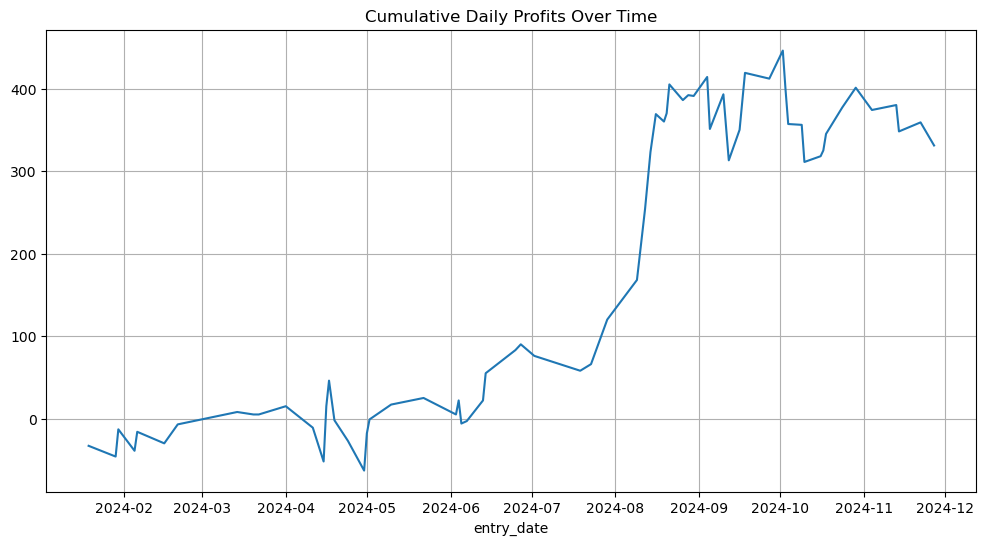

In [69]:
daily_profits.cumsum().plot(figsize=(12, 6), title='Cumulative Daily Profits Over Time', grid=True)

<Axes: title={'center': 'SPY Close Price Over Time'}, xlabel='timestamp'>

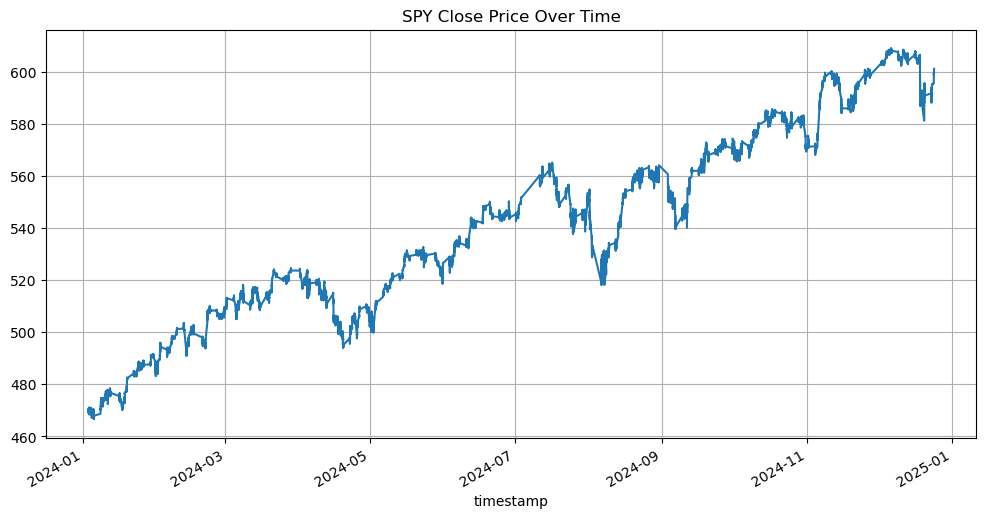

In [17]:
com_df['SPY_close'].plot(figsize=(12, 6), title='SPY Close Price Over Time', grid=True)